# Denoising mRNA data in scRNAseq

In this tutorial, we'll be walking through the steps to denoising mRNA counts in a species-mixing data. In this experiment, an equal number of human HEK293T cells and mouse NIH3T3 cells were pooled and sequenced, transcripts from the other organism were unambiguously ambient contamination, providing a ‘ground truth’ for the evaluation of scAR. The original dataset is downloaded from 10x genomics [dataset](https://www.10xgenomics.com/resources/datasets/20-k-1-1-mixture-of-human-hek-293-t-and-mouse-nih-3-t-3-cells-3-ht-v-3-1-3-1-high-6-1-0), and cell annotation file is available at [scAR-reproducibility/data](https://github.com/CaibinSh/scAR-reproducibility/tree/main/data)  
  
  - Run on your own device. You need to install several packages, [Scanpy](https://scanpy.readthedocs.io/en/stable/installation.html) and [scAR](https://github.com/CaibinSh/scAR/blob/main/README.md)
  - Run on Colab [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CaibinSh/scAR-reproducibility/blob/main/reproducibility/scAR_tutorial_mRNA_denoising.ipynb) **This option does not work at the moment, we will fix it soon**

In [ ]:
# Run this cell to install Scanpy and scAR in Colab
# Skip this cell if running on your own device

!pip install scanpy

!git clone https://github.com/CaibinSh/scAR.git
!pip install scAR/

!git clone https://github.com/CaibinSh/scAR-reproducibility.git
!cd scAR-reproducibility/reproducibility

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad
import scAR

import warnings
warnings.simplefilter("ignore")

In [3]:
from matplotlib import pylab

params = {'legend.fontsize': 8,
          'figure.facecolor':"w",
          'figure.figsize': (6, 4.5),
         'axes.labelsize': 10,
         'axes.titlesize':10,
         'axes.linewidth': 0.5,
         'xtick.labelsize':8,
         'ytick.labelsize':8,
         'axes.grid':False,}
pylab.rc('font',**{'family':'serif','serif':['Palatino'],'size':10})
pylab.rcParams.update(params);

sns.set_palette("muted");
sns.set_style("ticks");

## read data

The raw and filtered count matrices can be downloaded from 10x Dataset. We annotated cells by their cell species and provided the annotation file.

In [4]:
species_mix = sc.read_10x_h5(filename='../data/20k_hgmm_3p_HT_nextgem_Chromium_X_filtered_feature_bc_matrix.h5ad',
                             backup_url='https://cf.10xgenomics.com/samples/cell-exp/6.1.0/20k_hgmm_3p_HT_nextgem_Chromium_X/20k_hgmm_3p_HT_nextgem_Chromium_X_filtered_feature_bc_matrix.h5');
species_mix.var_names_make_unique();

# Cell annotation
species_mix_annotation = pd.read_csv('../data/species_mixing_cell_annotation.csv', index_col=0)
species_mix.obs=species_mix.obs.join(species_mix_annotation[['species']])

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
species_mix_raw = sc.read_10x_h5(filename='data/20k_hgmm_3p_HT_nextgem_Chromium_X_raw_feature_bc_matrix.h5ad',
                                 backup_url='https://cf.10xgenomics.com/samples/cell-exp/6.1.0/20k_hgmm_3p_HT_nextgem_Chromium_X/20k_hgmm_3p_HT_nextgem_Chromium_X_raw_feature_bc_matrix.h5');
species_mix_raw.var_names_make_unique();

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Gene and cell filtering

In [6]:
sc.pp.filter_genes(species_mix, min_counts=200);
sc.pp.filter_genes(species_mix, max_counts=6000);
sc.pp.filter_cells(species_mix, min_genes=200);

species_mix_raw = species_mix_raw[:, species_mix.var_names]

Calculate number of human and mouse transcripts

In [7]:
species_mix.obs['human gene counts'] = species_mix[:, species_mix.var['genome']=="GRCh38"].X.sum(axis=1).A1
species_mix.obs['mouse gene counts'] = species_mix[:, species_mix.var['genome']=="mm10"].X.sum(axis=1).A1

kneeplot to identify cell-free droplets

In [8]:
rank_UMIs = pd.DataFrame(species_mix_raw.X.sum(axis=1), index = species_mix_raw.obs_names, columns=['total_counts'])

rank_UMIs['droplets'] = 'cell-free droplets'
rank_UMIs['droplets'] = rank_UMIs['droplets'].mask(rank_UMIs['total_counts']>12, 'droplet II')
rank_UMIs['droplets'] = rank_UMIs['droplets'].mask(rank_UMIs['total_counts']>40, 'droplet I')
rank_UMIs['droplets'] = rank_UMIs['droplets'].mask(rank_UMIs.index.isin(species_mix.obs_names), 'cells')
rank_UMIs = rank_UMIs.sort_values(by='total_counts', ascending=False).reset_index().rename_axis("rank").reset_index()
rank_UMIs = rank_UMIs.loc[rank_UMIs['total_counts']>0]
rank_UMIs = rank_UMIs.set_index('index').rename_axis('cells')

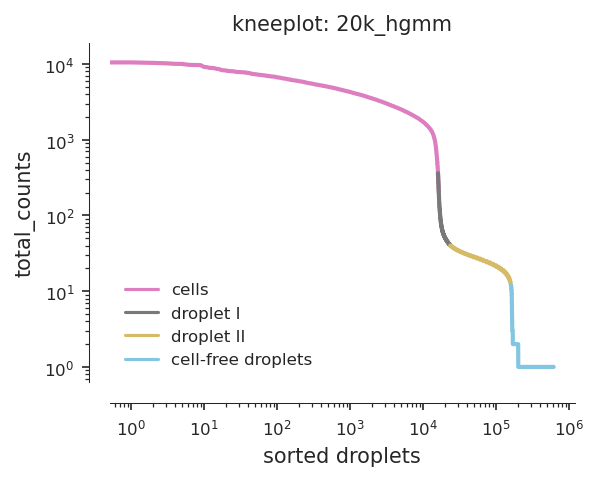

In [9]:
plt.figure(figsize=(4, 3), dpi=150)

ax = sns.lineplot(data = rank_UMIs,
                  x='rank',
                  y='total_counts',
                  hue='droplets',
                  hue_order=['cells', 'droplet I', 'droplet II', 'cell-free droplets'],
                  palette=sns.color_palette()[-4:],
                  markers=False,
                  lw=2)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('sorted droplets');
ax.legend(loc='lower left', ncol=1, title=None, frameon=False)
ax.set_title(f'kneeplot: 20k_hgmm');

sns.set_palette("muted")
sns.set_style("ticks")
sns.despine(offset=10, trim=False);

### Prepare inputs for scAR. 

The droplet I and II might contain cell debris, so we calculated ambient profile from the marked 'cell-free droplets'

In [10]:
non_cell_droplets = species_mix_raw[species_mix_raw.obs_names.isin(rank_UMIs[rank_UMIs['droplets']=='cell-free droplets'].index)].X.sum(axis=0)
empty_profile=(non_cell_droplets/non_cell_droplets.sum()).A1
empty_profile

array([5.4113139e-06, 9.1992340e-05, 1.2626399e-05, ..., 5.2309369e-05,
       2.3449027e-05, 2.1645255e-05], dtype=float32)

In [11]:
raw_counts = species_mix.to_df()
raw_counts.head()

,GRCh38_AL627309.5,GRCh38_LINC01128,GRCh38_LINC00115,GRCh38_FAM41C,GRCh38_AL645608.2,GRCh38_LINC02593,GRCh38_SAMD11,GRCh38_KLHL17,GRCh38_AL645608.7,GRCh38_ISG15,...,mm10___Gm21887,mm10___Kdm5d,mm10___Eif2s3y,mm10___Uty,mm10___Ddx3y,mm10___AC133103.1,mm10___AC168977.1,mm10___CAAA01118383.1,mm10___Spry3,mm10___Tmlhe
AAACCCAAGAGCCGAT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGCGTTCCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGTGCGTCC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCACAAACTGCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCACAATACCTG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Train scAR

In [12]:
scarObj = scAR.model(raw_count=raw_counts.values,
                     empty_profile=empty_profile, # In the case of default None, the empty_profile will be calculated by averaging pooled cells
                     scRNAseq_tech='scRNAseq')

scarObj.train(epochs=400,
              batch_size=64,)

# After training, we can infer the native true signal
scarObj.inference()  # by defaut, batch_size=None, set a batch_size if getting a GPU memory issue

..Running VAE using the following param set:
......scAR mode:  scRNAseq
......count model:  binomial
......num_input_feature:  16586
......NN_layer1:  150
......NN_layer2:  100
......latent_space:  15
......dropout_prob:  0
......kld_weight:  1e-05
......lr:  0.001
......lr_step_size:  5
......lr_gamma:  0.97
  Training.....
100%|██████████| 400/400 [11:15<00:00,  1.69s/it]
  Inferring .....


## Visualization

In [13]:
# The denoised counts are saved in scarObj.native_counts

denoised_count = pd.DataFrame(scarObj.native_counts, index=raw_counts.index, columns=raw_counts.columns)

Calculate number of human and mouse transcripts

In [14]:
raw_counts_df = species_mix.obs[['human gene counts', 'mouse gene counts']].astype(int)
raw_counts_df['human count ratio'] = raw_counts_df['human gene counts']/(raw_counts_df['mouse gene counts'] + raw_counts_df['human gene counts'])
raw_counts_df['mouse count ratio'] = raw_counts_df['mouse gene counts']/(raw_counts_df['mouse gene counts'] + raw_counts_df['human gene counts'])
raw_counts_df['log2(human gene counts+1)'] = np.log2(raw_counts_df['human gene counts']+1)
raw_counts_df['log2(mouse gene counts+1)'] = np.log2(raw_counts_df['mouse gene counts']+1)
raw_counts_df = raw_counts_df.join(species_mix.obs[['species']])

visualization of raw counts

<Figure size 600x600 with 0 Axes>

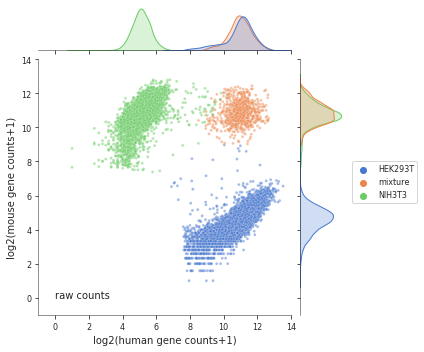

In [14]:
plt.figure(figsize=(4, 4), dpi=150)

ax = sns.jointplot(data=raw_counts_df,
                   x="log2(human gene counts+1)",
                   y="log2(mouse gene counts+1)",
                   hue='species',
                   hue_order=['HEK293T', 'mixture', 'NIH3T3'],
                   s=8,
                   alpha=0.5,
                   legend=True,
                   height=5,
                   marginal_kws={'common_norm':False});
ax.ax_joint.text(0, 0, 'raw counts');
ax.ax_joint.set_xlim(-1, 14);
ax.ax_joint.set_ylim(-1, 14);
ax.ax_joint.legend(bbox_to_anchor=(1.5, 0.6),borderaxespad=0)

Calculate number of human and mouse transcripts after denoising

In [15]:
denoised_count['human gene counts'] = denoised_count.loc[:,denoised_count.columns.str.startswith('GRCh38_')].sum(axis=1)
denoised_count['mouse gene counts'] = denoised_count.loc[:,denoised_count.columns.str.startswith('mm10_')].sum(axis=1)
denoised_count['human count ratio'] = denoised_count['human gene counts']/(denoised_count['mouse gene counts'] + denoised_count['human gene counts'])
denoised_count['mouse count ratio'] = denoised_count['mouse gene counts']/(denoised_count['mouse gene counts'] + denoised_count['human gene counts'])
denoised_count['species'] = raw_counts_df['species']
denoised_count['log2(human gene counts+1)'] = np.log2(denoised_count['human gene counts']+1)
denoised_count['log2(mouse gene counts+1)'] = np.log2(denoised_count['mouse gene counts']+1)

visualization of denoised counts

<Figure size 600x600 with 0 Axes>

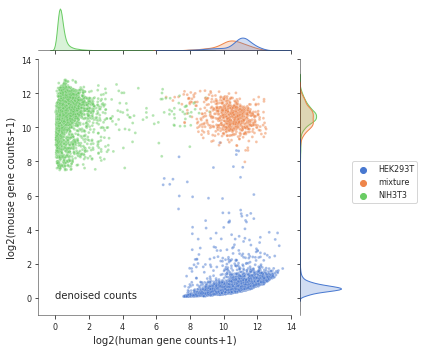

In [16]:
plt.figure(figsize=(4, 4), dpi=150)

ax = sns.jointplot(data=denoised_count,
                   x="log2(human gene counts+1)",
                   y="log2(mouse gene counts+1)",
                   hue='species',
                   hue_order=['HEK293T', 'mixture', 'NIH3T3'],
                   s=8,
                   alpha=0.5,
                   legend=True,
                   height=5,
                   marginal_kws={'common_norm':False});
ax.ax_joint.text(0, 0, 'denoised counts');
ax.ax_joint.set_xlim(-1, 14);
ax.ax_joint.set_ylim(-1, 14);
ax.ax_joint.legend(bbox_to_anchor=(1.5, 0.6),borderaxespad=0)